# Proyecto 3
## Laboratorio de Análisis Estadístico
## Integrantes
- Ana Sofía Hinojosa
- Julia Hernández
- Sara Hernández

# Objetivos

### Generales

### Específicos

# Marco Teórico

### Regresión lineal

#### 6 problemas potenciales en una regresión (ISLP)

### Árbol para regresión

### Árbol para clasificación

### Bootstrap

### Ensambles de modelos

### Bagging

### Boosting

### Tema elegido para proyecto


## Análisis del dataset

## Modelos propuestos

### Random Forest para clasificación

### XGBoost para clasificación

## Pipeline
![La imagen del pipeline se puede encontrar en el repositorio como 'pipeline.jpeg'](pipeline.jpg)

## Código

### Importación de librerías

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import os

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


### Análisis del dataset

In [2]:
data = pd.read_csv('Loan_approval_data_2025.csv')
data = data.drop(columns=['customer_id'])
data = data.dropna()

In [3]:
info_df = pd.DataFrame({
    'column': data.columns,
    'dtype': data.dtypes.values,
    'non_nulls': data.notnull().sum().values,
    'nulls': data.isnull().sum().values
})

info_df

,column,dtype,non_nulls,nulls
0,age,int64,50000,0
1,occupation_status,object,50000,0
2,years_employed,float64,50000,0
3,annual_income,int64,50000,0
4,credit_score,int64,50000,0
5,credit_history_years,float64,50000,0
6,savings_assets,int64,50000,0
7,current_debt,int64,50000,0
8,defaults_on_file,int64,50000,0
9,delinquencies_last_2yrs,int64,50000,0


In [4]:
data = pd.get_dummies(data, columns=['product_type', 'occupation_status', 'loan_intent'], drop_first=True)
data

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,loan_status,product_type_Line of Credit,product_type_Personal Loan,occupation_status_Self-Employed,occupation_status_Student,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,40,17.2,25579,692,5.3,895,10820,0,0,0,...,1,False,False,False,False,False,False,False,False,False
1,33,7.3,43087,627,3.5,169,16550,0,1,0,...,0,False,True,False,False,False,False,True,False,False
2,42,1.1,20840,689,8.4,17,7852,0,0,0,...,1,False,False,False,True,True,False,False,False,False
3,53,0.5,29147,692,9.8,1480,11603,0,1,0,...,1,False,False,False,True,False,False,False,False,False
4,32,12.5,63657,630,7.2,209,12424,0,0,0,...,1,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,35,4.3,39449,570,16.3,1127,7576,0,0,0,...,0,False,False,False,False,False,True,False,False,False
49996,34,4.4,20496,672,12.6,1478,6276,1,0,0,...,0,False,False,False,False,False,False,False,False,True
49997,41,4.8,18743,719,10.1,17,10331,0,0,0,...,0,False,False,True,False,False,False,False,False,True
49998,38,0.4,17250,633,1.3,5,7779,0,0,1,...,0,False,True,False,True,False,False,False,False,True


In [5]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols] = StandardScaler().fit_transform(X[numerical_cols])
X

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,payment_to_income_ratio,product_type_Line of Credit,product_type_Personal Loan,occupation_status_Self-Employed,occupation_status_Student,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,0.453563,1.280229,-0.750345,0.747482,-0.397958,-0.204093,-0.262046,-0.237701,-0.656347,-0.357489,...,-1.455529,False,False,False,False,False,False,False,False,False
1,-0.176018,-0.020345,-0.213787,-0.256675,-0.647698,-0.258959,0.170615,-0.237701,0.527028,-0.357489,...,1.146448,False,True,False,False,False,False,True,False,False
2,0.633444,-0.834846,-0.895579,0.701137,0.032151,-0.270446,-0.486154,-0.237701,-0.656347,-0.357489,...,-1.288075,False,False,False,True,True,False,False,False,False
3,1.622787,-0.913669,-0.640998,0.747482,0.226393,-0.159883,-0.202923,-0.237701,0.527028,-0.357489,...,-1.294515,False,False,False,True,False,False,False,False,False
4,-0.265959,0.662785,0.416612,-0.210330,-0.134343,-0.255936,-0.140931,-0.237701,-0.656347,-0.357489,...,1.854907,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.003862,-0.414459,-0.325278,-1.137244,1.128234,-0.186561,-0.506994,-0.237701,-0.656347,-0.357489,...,0.824421,False,False,False,False,False,True,False,False,False
49996,-0.086078,-0.401322,-0.906121,0.438511,0.614879,-0.160035,-0.605155,4.206968,-0.656347,-0.357489,...,-1.107740,False,False,False,False,False,False,False,False,True
49997,0.543504,-0.348773,-0.959844,1.164594,0.268017,-0.270446,-0.298970,-0.237701,-0.656347,-0.357489,...,0.553919,False,False,True,False,False,False,False,False,True
49998,0.273683,-0.926806,-1.005600,-0.163984,-0.952937,-0.271353,-0.491666,-0.237701,-0.656347,2.063865,...,-1.333159,False,True,False,True,False,False,False,False,True


### Modelos

In [6]:
model_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgboost = xgb.XGBClassifier(eval_metric='logloss', tree_method='hist', n_estimators=100, random_state=42)
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
variables_importances_random_forest = pd.DataFrame({
    'feature': X.columns,
    'importance_random_forest': model_random_forest.fit(X, y).feature_importances_,
}).sort_values(by='importance_random_forest', ascending=False)

variables_importances_random_forest

,feature,importance_random_forest
3,credit_score,0.204656
12,debt_to_income_ratio,0.169741
11,interest_rate,0.066342
4,credit_history_years,0.064787
8,delinquencies_last_2yrs,0.062069
0,age,0.046416
13,loan_to_income_ratio,0.045991
14,payment_to_income_ratio,0.044099
7,defaults_on_file,0.039897
1,years_employed,0.039123


In [8]:
variables_importances_xgboost = pd.DataFrame({
    'feature': X.columns,
    'importance_xgboost': model_xgboost.fit(X, y).feature_importances_,
}).sort_values(by='importance_xgboost', ascending=False)

variables_importances_xgboost

,feature,importance_xgboost
7,defaults_on_file,0.160836
3,credit_score,0.136706
12,debt_to_income_ratio,0.079668
8,delinquencies_last_2yrs,0.078596
19,loan_intent_Debt Consolidation,0.065321
23,loan_intent_Personal,0.063546
20,loan_intent_Education,0.062345
14,payment_to_income_ratio,0.054532
22,loan_intent_Medical,0.051371
9,derogatory_marks,0.038310


In [9]:
scores_random_forest = cross_val_score(
    model_random_forest, X, y, cv=k_folds, scoring='roc_auc', n_jobs=-1
)

scores_xgboost = cross_val_score(
    model_xgboost, X, y, cv=k_folds, scoring='roc_auc', n_jobs=-1,
)

print("Random Forest Classifier ROC AUC: %.2f%% (+/- %.2f%%)" % 
      (scores_random_forest.mean()*100, scores_random_forest.std()*100))

print("XGBoost Classifier ROC AUC: %.2f%% (+/- %.2f%%)" % 
      (scores_xgboost.mean()*100, scores_xgboost.std()*100))

Random Forest Classifier ROC AUC: 97.29% (+/- 0.11%)
XGBoost Classifier ROC AUC: 98.32% (+/- 0.07%)


### Optimización de hiperparámetros

In [10]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective_random_forest(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_categorical("max_depth", [None, 5, 10, 20, 30]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }
    model = RandomForestClassifier(**params, n_jobs=-1)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    trial.set_user_attr("std", float(scores.std()))

    return scores.mean()

study_random_forest = optuna.create_study(direction="maximize")
study_random_forest.optimize(objective_random_forest, n_trials=50, show_progress_bar=True)  

print("Best Random Forest Parameters:")
print(study_random_forest.best_trial.params)

print("Mean ROC AUC:", study_random_forest.best_trial.value)
print("Std ROC AUC:", study_random_forest.best_trial.user_attrs["std"])

Best trial: 10. Best value: 0.974201: 100%|██████████| 50/50 [19:48<00:00, 23.78s/it]

Best Random Forest Parameters:
{'n_estimators': 799, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
Mean ROC AUC: 0.9742005560461757
Std ROC AUC: 0.001347766649609616


In [11]:
def objective_xgboost(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "tree_method": "hist",
        "eval_metric": "logloss",
    }

    model = xgb.XGBClassifier(**params, n_jobs=-1)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    trial.set_user_attr("std", float(scores.std()))

    return scores.mean()

study_xgboost = optuna.create_study(direction="maximize")
study_xgboost.optimize(objective_xgboost, n_trials=50, show_progress_bar=True) 

print("Best XGBoost Classifier Trial:")
print(study_xgboost.best_trial.params)

print("Mean ROC AUC:", study_xgboost.best_trial.value)
print("Std ROC AUC:", study_xgboost.best_trial.user_attrs["std"])

Best trial: 42. Best value: 0.985192: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]

Best XGBoost Classifier Trial:
{'n_estimators': 230, 'max_depth': 3, 'gamma': 3.6614706910354853, 'learning_rate': 0.17665796746458662}
Mean ROC AUC: 0.9851919282540456
Std ROC AUC: 0.0005747957281437178


### Resultados

#### Resultados de la optimización

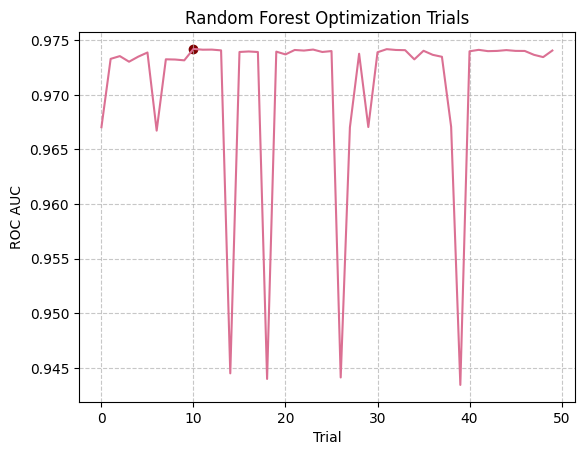

In [12]:
df_optim_rf = pd.DataFrame(study_random_forest.trials_dataframe())
best_value = df_optim_rf['value'].max()
plt.plot(df_optim_rf['value'], color='palevioletred')
plt.title('Random Forest Optimization Trials')
plt.scatter(df_optim_rf.index[df_optim_rf['value'] == best_value],
            best_value,
            color='maroon',
            label='Best Value')
plt.xlabel('Trial')
plt.ylabel('ROC AUC')
plt.grid(linestyle='--', alpha=0.7)

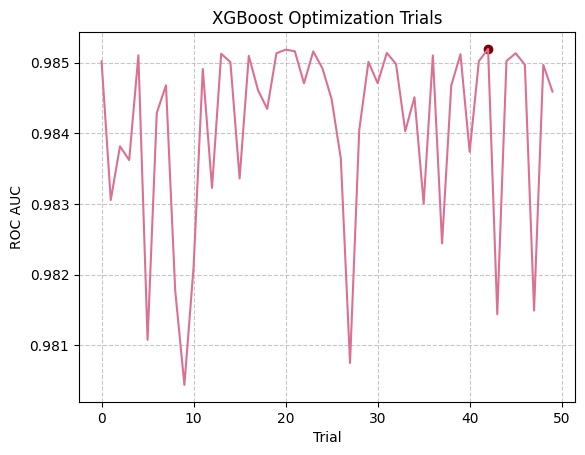

In [13]:
df_optim_xgb = pd.DataFrame(study_xgboost.trials_dataframe())
best_value = df_optim_xgb['value'].max()
plt.plot(df_optim_xgb['value'], color='palevioletred')
plt.title('XGBoost Optimization Trials')
plt.scatter(df_optim_xgb.index[df_optim_xgb['value'] == best_value],
            best_value,
            color='maroon',
            label='Best Value')
plt.xlabel('Trial')
plt.ylabel('ROC AUC')
plt.grid(linestyle='--', alpha=0.7)

### Hiperparámetros óptimos por modelo

In [14]:
pd.DataFrame({
    "Random Forest": study_random_forest.best_trial.params,
})

,Random Forest
n_estimators,799
max_depth,30
min_samples_split,2
min_samples_leaf,1


In [15]:
pd.DataFrame({
    "XGBoost": study_xgboost.best_trial.params,
})

,XGBoost
n_estimators,230.000000
max_depth,3.000000
gamma,3.661471
learning_rate,0.176658


#### Tabla comparativa de resultados

In [16]:
tipos = ['Random Forest sin optimizacion', 'Random Forest optimizado', 'XGBoost sin optimizacion', 'XGBoost optimizado']
pd.DataFrame({
    "Modelo utilizasdo": tipos,
    "Media de ROC AUC": [
        scores_random_forest.mean(),
        study_random_forest.best_trial.value,
        scores_xgboost.mean(),
        study_xgboost.best_trial.value
    ],
    "Desviacion estandar de ROC AUC": [
        scores_random_forest.std(),
        study_random_forest.best_trial.user_attrs["std"],
        scores_xgboost.std(),
        study_xgboost.best_trial.user_attrs["std"]
    ]
})

,Modelo utilizasdo,Media de ROC AUC,Desviacion estandar de ROC AUC
0,Random Forest sin optimizacion,0.972886,0.001142
1,Random Forest optimizado,0.974201,0.001348
2,XGBoost sin optimizacion,0.983201,0.000686
3,XGBoost optimizado,0.985192,0.000575


### ROC AUC

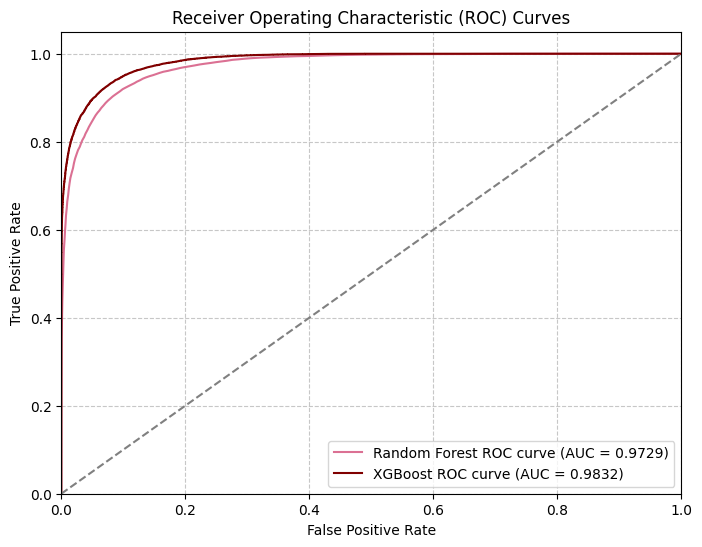

In [18]:
y_pred_rf = cross_val_predict(
    model_random_forest, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1]
y_pred_xgb = cross_val_predict(
    model_xgboost, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y, y_pred_xgb)
roc_auc_fold_rf = roc_auc_score(y, y_pred_rf)
roc_auc_fold_xgb = roc_auc_score(y, y_pred_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='palevioletred', label=f'Random Forest ROC curve (AUC = {roc_auc_fold_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='maroon', label=f'XGBoost ROC curve (AUC = {roc_auc_fold_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.7)

### Matrices de confusión

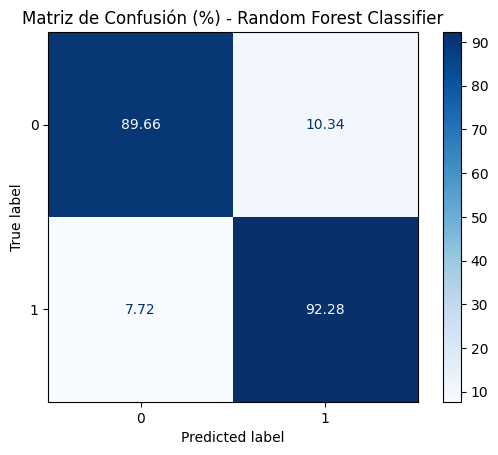

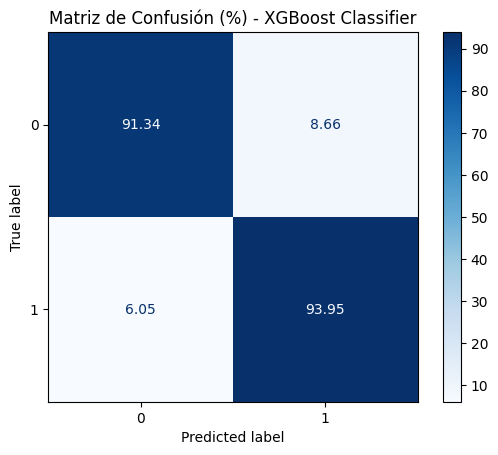

In [28]:
matriz_rf = cross_val_predict(model_random_forest, X, y, cv=k_folds, n_jobs=-1)
matriz_xgb = cross_val_predict(model_xgboost, X, y, cv=k_folds, n_jobs=-1)

cm_rf = confusion_matrix(y, matriz_rf, normalize='true') * 100
cm_xgb = confusion_matrix(y, matriz_xgb, normalize='true') * 100

# Plot RF
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues', values_format='.2f') 
plt.title('Matriz de Confusión (%) - Random Forest Classifier')

# Plot XGB
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusión (%) - XGBoost Classifier')

plt.show()


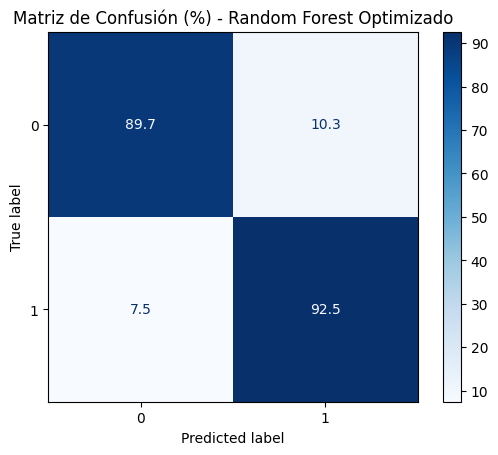

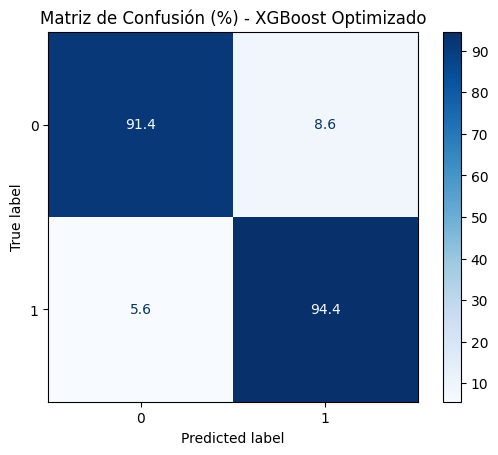

In [29]:
best_params_rf = study_random_forest.best_trial.params

model_rf_best = RandomForestClassifier(
    **best_params_rf,
    n_jobs=-1
)

matriz_rf_best = cross_val_predict(
    model_rf_best,
    X,
    y,
    cv=5,
    method='predict',
    n_jobs=-1
)

cm_rf_best = confusion_matrix(y, matriz_rf_best, normalize='true') * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_best)
disp.plot(cmap='Blues', values_format='.1f')
plt.title('Matriz de Confusión (%) - Random Forest Optimizado')
plt.show()

best_params_xgb = study_xgboost.best_trial.params

model_xgb_best = xgb.XGBClassifier(
    **best_params_xgb,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss"
)

matriz_xgb_best = cross_val_predict(
    model_xgb_best,
    X,
    y,
    cv=5,
    method='predict',
    n_jobs=-1
)

cm_xgb_best = confusion_matrix(y, matriz_xgb_best, normalize='true') * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best)
disp.plot(cmap='Blues', values_format='.1f')
plt.title('Matriz de Confusión (%) - XGBoost Optimizado')
plt.show()

## Conclusiones